# Hello Feature Class example: using the feature classes to calculate features

This example shows how to use the Radiomics package to directly instantiate the feature classes for feature extraction. 
Note that this is not the intended standard use. For an example on the standard use with feature extractor, see the `helloRadiomics` example.

In [1]:
from __future__ import print_function
import os
import collections
import SimpleITK as sitk
import numpy
import six
import radiomics
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Getting the test case

Test cases can be downloaded to temporary files. This is handled by the `radiomics.getTestCase()` function, which checks if the requested test case is available and if not, downloads it. It returns a tuple with the location of the image and mask of the requested test case, or (None, None) if it fails.

Alternatively, if the data is available somewhere locally, this directory can be passed as a second argument to `radiomics.getTestCase()`. If that directory does not exist or does not contain the testcase, functionality reverts to default and tries to download the test data.

If getting the test case fails, PyRadiomics will log an error explaining the cause.

In [3]:
filename = r'E:\Data\HeronTech\SDFY\mass0508\Crops_M\crop_patches_512\00633270-1_0_1.0_0.0_512.png'
data = sitk.ReadImage(filename)

In [4]:
spacing = data.GetSpacing()
direction = data.GetDirection()
origin = data.GetOrigin()

In [5]:
spacing,direction,origin

((1.0, 1.0), (1.0, 0.0, 0.0, 1.0), (0.0, 0.0))

In [6]:
data = sitk.GetArrayFromImage(data)

In [7]:
data=data.astype('int16')

(<matplotlib.image.AxesImage at 0x145a4906ac8>,
 <matplotlib.colorbar.Colorbar at 0x145a494e128>)

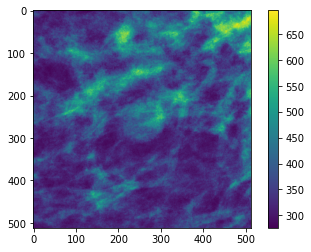

In [8]:
data.shape
plt.imshow(data[:,:,1]*3),plt.colorbar()

In [9]:
cropd = data[:,:,1]
cropm = data[:,:,0]

In [10]:
cropdd = sitk.GetImageFromArray(cropd)
cropmm = sitk.GetImageFromArray(cropm)

In [11]:
cropdata = sitk.JoinSeries(cropdd)
cropmask = sitk.JoinSeries(cropmm)

In [12]:
cropdata.GetSpacing()

(1.0, 1.0, 1.0)

## Preprocess the image

#### Extraction Settings

In [13]:
settings = {}
settings['binWidth'] = 1
settings['resampledPixelSpacing'] = None
# settings['resampledPixelSpacing'] = [3, 3, 3]  # This is an example for defining resampling (voxels with size 3x3x3mm)
settings['interpolator'] = 'sitkBSpline'
settings['verbose'] = True

#### If enabled, resample the image

In [14]:
# Resample if necessary
interpolator = settings.get('interpolator')
resampledPixelSpacing = settings.get('resampledPixelSpacing')
if interpolator is not None and resampledPixelSpacing is not None:
  cropdata, cropmask = imageoperations.resampleImage(cropdata, cropmask, **settings)

## Calculate features using original image

In [25]:
# Crop the image
# bb is the bounding box, upon which the image and mask are cropped
bb, correctedMask = imageoperations.checkMask(cropdata, cropmask, label=255)
if correctedMask is not None:
    print(correctedMask)
    cropmask = correctedMask
croppedImage, croppedMask = imageoperations.cropToTumorMask(cropdata, cropmask, bb)

In [16]:
cropms = sitk.GetArrayFromImage(croppedMask)

In [17]:
np.shape(cropms)

(1, 107, 119)

(<matplotlib.image.AxesImage at 0x145a59edcc0>,
 <matplotlib.colorbar.Colorbar at 0x145a5a2d320>)

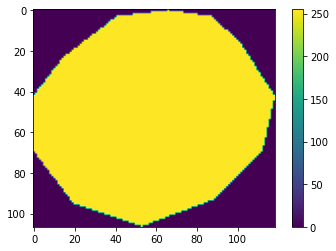

In [18]:
plt.imshow(cropms[0,:,:]),plt.colorbar()

### Calculate Firstorder features

In [19]:
croppedImage

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x00000145A4496AB0> >

In [29]:
firstOrderFeatures = firstorder.RadiomicsFirstOrder(croppedImage, croppedMask,label = 255, **settings)

# Set the features to be calculated
firstOrderFeatures.enableFeatureByName('Mean', True)
# firstOrderFeatures.enableAllFeatures()

In [30]:
# Print out the docstrings of the enabled features
print('Will calculate the following first order features: ')
for f in firstOrderFeatures.enabledFeatures.keys():
  print(f)
  print(getattr(firstOrderFeatures, 'get%sFeatureValue' % f).__doc__)

Will calculate the following first order features: 
Mean

    **8. Mean**

    .. math::
      \textit{mean} = \frac{1}{N_p}\displaystyle\sum^{N_p}_{i=1}{\textbf{X}(i)}

    The average gray level intensity within the ROI.
    


In [31]:
# Calculate the features and print(out result)
print('Calculating first order features...',)
result = firstOrderFeatures.execute()
print('done')

print('Calculated first order features: ')
for (key, val) in six.iteritems(result):
  print('  ', key, ':', val)

Calculating first order features...
done
Calculated first order features: 
   Mean : 139.5243522201914


### Calculate Shape Features

In [32]:
shapeFeatures = shape.RadiomicsShape(croppedImage, croppedMask, label=255,**settings)

# Set the features to be calculated
# shapeFeatures.enableFeatureByName('Volume', True)
shapeFeatures.enableAllFeatures()

In [33]:
# Print out the docstrings of the enabled features
print('Will calculate the following shape features: ')
for f in shapeFeatures.enabledFeatures.keys():
  print(f)
  print(getattr(shapeFeatures, 'get%sFeatureValue' % f).__doc__)

Will calculate the following shape features: 
Elongation

    **16. Elongation**

    Elongation shows the relationship between the two largest principal components in the ROI shape.
    For computational reasons, this feature is defined as the inverse of true elongation.

    .. math::
      \textit{elongation} = \sqrt{\frac{\lambda_{minor}}{\lambda_{major}}}

    Here, :math:`\lambda_{\text{major}}` and :math:`\lambda_{\text{minor}}` are the lengths of the largest and second
    largest principal component axes. The values range between 1 (where the cross section through the first and second
    largest principal moments is circle-like (non-elongated)) and 0 (where the object is a maximally elongated: i.e. a 1
    dimensional line).

    The principal component analysis is performed using the physical coordinates of the voxel centers defining the ROI.
    It therefore takes spacing into account, but does not make use of the shape mesh.
    
Flatness

    **17. Flatness**

    Flatnes

In [34]:
# Calculate the features and print(out result)
print('Calculating shape features...',)
result = shapeFeatures.execute()
print('done')

print('Calculated shape features: ')
for (key, val) in six.iteritems(result):
  print('  ', key, ':', val)

Calculating shape features...
done
Calculated shape features: 
   Elongation : 0.8501793981214746
   Flatness : 0.0
   LeastAxisLength : 0.0
   MajorAxisLength : 118.1240671324952
   Maximum2DDiameterColumn : 119.0
   Maximum2DDiameterRow : 105.0
   Maximum2DDiameterSlice : 122.0245876862528
   Maximum3DDiameter : 122.0245876862528
   MeshVolume : 9224.416666666666
   MinorAxisLength : 100.42664829836544
   Sphericity : 0.11330146620714512
   SurfaceArea : 18773.325160759494
   SurfaceVolumeRatio : 2.035177490257866
   VoxelVolume : 9301.0


### Calculate GLCM Features

In [35]:
glcmFeatures = glcm.RadiomicsGLCM(croppedImage, croppedMask,label=255, **settings)

# Set the features to be calculated
# glcmFeatures.enableFeatureByName('SumEntropy', True)
glcmFeatures.enableAllFeatures()

In [36]:
# Print out the docstrings of the enabled features
print('Will calculate the following GLCM features: ')
for f in glcmFeatures.enabledFeatures.keys():
  print(f)
  print(getattr(glcmFeatures, 'get%sFeatureValue' % f).__doc__)

Will calculate the following GLCM features: 
Autocorrelation

    **1. Autocorrelation**

    .. math::
      \textit{autocorrelation} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}{p(i,j)ij}

    Autocorrelation is a measure of the magnitude of the fineness and coarseness of texture.
    
ClusterProminence

    **3. Cluster Prominence**

    .. math::
      \textit{cluster prominence} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}
      {\big( i+j-\mu_x-\mu_y\big)^4p(i,j)}

    Cluster Prominence is a measure of the skewness and asymmetry of the GLCM. A higher values implies more asymmetry
    about the mean while a lower value indicates a peak near the mean value and less variation about the mean.
    
ClusterShade

    **4. Cluster Shade**

    .. math::
      \textit{cluster shade} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}
      {\big(i+j-\mu_x-\mu_y\big)^3p(i,j)}

    Cluster Shade is a measure of the skewness and uniformity of the GL

In [37]:
# Calculate the features and print(out result)
print('Calculating GLCM features...',)
result = glcmFeatures.execute()
print('done')

print('Calculated GLCM features: ')
for (key, val) in six.iteritems(result):
  print('  ', key, ':', val)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Calculating GLCM features...
done
Calculated GLCM features: 
   Autocorrelation : 1963.3138878659688
   ClusterProminence : 4663225.006114157
   ClusterShade : 25277.43077849681
   ClusterTendency : 1277.1800497324473
   Contrast : 65.53044506796364
   Correlation : 0.9023822817403881
   DifferenceAverage : 6.359782462803671
   DifferenceEntropy : 4.110475570493729
   DifferenceVariance : 25.02218337079093
   Id : 0.23878257146726758
   Idm : 0.14741259523356806
   Idmn : 0.9937063706087041
   Idn : 0.9427189481152447
   Imc1 : -0.22162372719585094
   Imc2 : 0.9667455612326701
   InverseVariance : 0.15101637119939226
   JointAverage : 40.74798992158584
   JointEnergy : 0.0006627062553241197
   JointEntropy : 10.961706093903866
   MCC : 0.9050198109802918
   MaximumProbability : 0.0022361150456114455
   SumAverage : 81.4959798431716
   SumEntropy : 7.116672049258263
   SumSquares : 335.6776237001032


### Calculate GLRLM Features

In [38]:
glrlmFeatures = glrlm.RadiomicsGLRLM(croppedImage, croppedMask,label=255, **settings)

# Set the features to be calculated
# glrlmFeatures.enableFeatureByName('ShortRunEmphasis', True)
glrlmFeatures.enableAllFeatures()

In [39]:
# Print out the docstrings of the enabled features
print('Will calculate the following GLRLM features: ')
for f in glrlmFeatures.enabledFeatures.keys():
  print(f)
  print(getattr(glrlmFeatures, 'get%sFeatureValue' % f).__doc__)

Will calculate the following GLRLM features: 
GrayLevelNonUniformity

    **3. Gray Level Non-Uniformity (GLN)**

    .. math::
      \textit{GLN} = \frac{\sum^{N_g}_{i=1}\left(\sum^{N_r}_{j=1}{\textbf{P}(i,j|\theta)}\right)^2}{N_r(\theta)}

    GLN measures the similarity of gray-level intensity values in the image, where a lower GLN value correlates with a
    greater similarity in intensity values.
    
GrayLevelNonUniformityNormalized

    **4. Gray Level Non-Uniformity Normalized (GLNN)**

    .. math::
      \textit{GLNN} = \frac{\sum^{N_g}_{i=1}\left(\sum^{N_r}_{j=1}{\textbf{P}(i,j|\theta)}\right)^2}{N_r(\theta)^2}

    GLNN measures the similarity of gray-level intensity values in the image, where a lower GLNN value correlates with a
    greater similarity in intensity values. This is the normalized version of the GLN formula.
    
GrayLevelVariance

    **8. Gray Level Variance (GLV)**

    .. math::
      \textit{GLV} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_r}_{j=

In [40]:
# Calculate the features and print(out result)
print('Calculating GLRLM features...',)
result = glrlmFeatures.execute()
print('done')

print('Calculated GLRLM features: ')
for (key, val) in six.iteritems(result):
  print('  ', key, ':', val)

Calculating GLRLM features...
done
Calculated GLRLM features: 
   GrayLevelNonUniformity : 141.13867824520838
   GrayLevelNonUniformityNormalized : 0.016013491025326714
   GrayLevelVariance : 337.80435690122283
   HighGrayLevelRunEmphasis : 1994.032715918917
   LongRunEmphasis : 1.1741132190835128
   LongRunHighGrayLevelEmphasis : 2291.3624407108823
   LongRunLowGrayLevelEmphasis : 0.0023403248783667365
   LowGrayLevelRunEmphasis : 0.0019743188625380615
   RunEntropy : 6.46777218235774
   RunLengthNonUniformity : 7950.126480630464
   RunLengthNonUniformityNormalized : 0.9019976478924743
   RunPercentage : 0.9476131598752822
   RunVariance : 0.060455624154156166
   ShortRunEmphasis : 0.9608816771952153
   ShortRunHighGrayLevelEmphasis : 1925.5124320128252
   ShortRunLowGrayLevelEmphasis : 0.0018946551179679816


### Calculate GLSZM Features

In [43]:
glszmFeatures = glszm.RadiomicsGLSZM(croppedImage, croppedMask,label=255, **settings)

# Set the features to be calculated
# glszmFeatures.enableFeatureByName('LargeAreaEmphasis', True)
glszmFeatures.enableAllFeatures()

In [44]:
# Print out the docstrings of the enabled features
print('Will calculate the following GLSZM features: ')
for f in glszmFeatures.enabledFeatures.keys():
  print(f)
  print(getattr(glszmFeatures, 'get%sFeatureValue' % f).__doc__)

Will calculate the following GLSZM features: 
GrayLevelNonUniformity

    **3. Gray Level Non-Uniformity (GLN)**

    .. math::
      \textit{GLN} = \frac{\sum^{N_g}_{i=1}\left(\sum^{N_s}_{j=1}{\textbf{P}(i,j)}\right)^2}{N_z}

    GLN measures the variability of gray-level intensity values in the image, with a lower value indicating more
    homogeneity in intensity values.
    
GrayLevelNonUniformityNormalized

    **4. Gray Level Non-Uniformity Normalized (GLNN)**

    .. math::
      \textit{GLNN} = \frac{\sum^{N_g}_{i=1}\left(\sum^{N_s}_{j=1}{\textbf{P}(i,j)}\right)^2}{N_z^2}

    GLNN measures the variability of gray-level intensity values in the image, with a lower value indicating a greater
    similarity in intensity values. This is the normalized version of the GLN formula.
    
GrayLevelVariance

    **8. Gray Level Variance (GLV)**

    .. math::
      \textit{GLV} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_s}_{j=1}{p(i,j)(i - \mu)^2}

    Here, :math:`\mu = \displa

In [45]:
# Calculate the features and print(out result)
print('Calculating GLSZM features...',)
result = glszmFeatures.execute()
print('done')

print('Calculated GLSZM features: ')
for (key, val) in six.iteritems(result):
  print('  ', key, ':', val)

Calculating GLSZM features...
done
Calculated GLSZM features: 
   GrayLevelNonUniformity : 119.0109581718562
   GrayLevelNonUniformityNormalized : 0.015904177224623308
   GrayLevelVariance : 337.39123600201435
   HighGrayLevelZoneEmphasis : 2036.8072965388212
   LargeAreaEmphasis : 1.9354536950420955
   LargeAreaHighGrayLevelEmphasis : 3585.0847253775223
   LargeAreaLowGrayLevelEmphasis : 0.00400691522238057
   LowGrayLevelZoneEmphasis : 0.001959631013051135
   SizeZoneNonUniformity : 5233.818655619404
   SizeZoneNonUniformityNormalized : 0.6994278572256319
   SmallAreaEmphasis : 0.8620425629368956
   SmallAreaHighGrayLevelEmphasis : 1781.577123480919
   SmallAreaLowGrayLevelEmphasis : 0.0016975198602414534
   ZoneEntropy : 7.004600070673217
   ZonePercentage : 0.8045371465433825
   ZoneVariance : 0.39052728167899986


## Calculate Features using Laplacian of Gaussian Filter

Calculating features on filtered images is very similar to calculating features on the original image. All filters in PyRadiomics have the same input and output signature, and there is even one for applying no filter. This enables to loop over a list of requested filters and apply them in the same piece of code. It is applied like this in the execute function in feature extractor. The input for the filters is the image, with additional keywords. If no additional keywords are supplied, the filter uses default values where applicable. It returns a [generator object](https://docs.python.org/2/reference/simple_stmts.html?#yield), allowing to define the generators to be applied before the filters functions are actually called.

In [49]:
image = cropdata
mask = cropmask

### Calculate Firstorder on LoG filtered images

In [47]:
logFeatures = {}
sigmaValues = [1.0, 3.0, 5.0]
for logImage, imageTypename, inputSettings in imageoperations.getLoGImage(cropdata, cropmask, sigma=sigmaValues):
  logImage, croppedMask = imageoperations.cropToTumorMask(logImage, mask, bb)
  logFirstorderFeatures = firstorder.RadiomicsFirstOrder(logImage, croppedMask, **inputSettings)
  logFirstorderFeatures.enableAllFeatures()
  logFeatures[imageTypename] = logFirstorderFeatures.execute()

Image too small to apply LoG filter, size: [512 512   1]


In [48]:
# Show result
for sigma, features in six.iteritems(logFeatures):
  for (key, val) in six.iteritems(features):
    laplacianFeatureName = '%s_%s' % (str(sigma), key)
    print('  ', laplacianFeatureName, ':', val)

## Calculate Features using Wavelet filter

### Calculate Firstorder on filtered images

In [51]:
waveletFeatures = {}
for decompositionImage, decompositionName, inputSettings in imageoperations.getWaveletImage(image, mask):
  decompositionImage, croppedMask = imageoperations.cropToTumorMask(decompositionImage, mask, bb)
  waveletFirstOrderFeaturs = firstorder.RadiomicsFirstOrder(decompositionImage, croppedMask, label=255, **inputSettings)
  waveletFirstOrderFeaturs.enableAllFeatures()

  print('Calculate firstorder features with ', decompositionName)
  waveletFeatures[decompositionName] = waveletFirstOrderFeaturs.execute()

Calculate firstorder features with  wavelet-LLH
Calculate firstorder features with  wavelet-LHL
Calculate firstorder features with  wavelet-LHH
Calculate firstorder features with  wavelet-HLL
Calculate firstorder features with  wavelet-HLH
Calculate firstorder features with  wavelet-HHL
Calculate firstorder features with  wavelet-HHH
Calculate firstorder features with  wavelet-LLL


In [52]:
# Show result
for decompositionName, features in six.iteritems(waveletFeatures):
  for (key, val) in six.iteritems(features):
    waveletFeatureName = '%s_%s' % (str(decompositionName), key)
    print('  ', waveletFeatureName, ':', val)

   wavelet-LLH_10Percentile : 1.3766765505351941e-14
   wavelet-LLH_90Percentile : 5.062616992290714e-14
   wavelet-LLH_Energy : 1.1495824044398602e-23
   wavelet-LLH_Entropy : 0.06466104967715129
   wavelet-LLH_InterquartileRange : 1.865174681370263e-14
   wavelet-LLH_Kurtosis : 3.491250014394826
   wavelet-LLH_Maximum : 1.0480505352461478e-13
   wavelet-LLH_MeanAbsoluteDeviation : 1.1554085634742062e-14
   wavelet-LLH_Mean : 3.191049068774561e-14
   wavelet-LLH_Median : 3.108624468950438e-14
   wavelet-LLH_Minimum : -1.9539925233402755e-14
   wavelet-LLH_Range : 1.2434497875801753e-13
   wavelet-LLH_RobustMeanAbsoluteDeviation : 7.929797516586485e-15
   wavelet-LLH_RootMeanSquared : 3.5156467563244917e-14
   wavelet-LLH_Skewness : 0.3932419271217591
   wavelet-LLH_TotalEnergy : 1.1495824044398602e-23
   wavelet-LLH_Uniformity : 0.9848493677524619
   wavelet-LLH_Variance : 2.1769779559279293e-28
   wavelet-LHL_10Percentile : -9.830452414730598
   wavelet-LHL_90Percentile : 9.646418316